In [1]:
include("IsingCore.jl")
using .IsingCore
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

println(names(IsingCore))

[:IsingCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [2]:
N = 12
β_min = 0
β_max = 1
M = 20
mcSteps=10^3
eqSteps=10^2
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_ladder = Utils.set_temperature_ladder(β_min, β_max; M=M)
exchange_prob_means, _ = IsingCore.calc_acceptance_and_rtt(
    N, 
    init_β_ladder
)

println(init_β_ladder)
println(exchange_prob_means)

[0.0, 0.05263157894736842, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.42105263157894735, 0.47368421052631576, 0.5263157894736842, 0.5789473684210527, 0.631578947368421, 0.6842105263157895, 0.7368421052631579, 0.7894736842105263, 0.8421052631578947, 0.8947368421052632, 0.9473684210526315, 1.0]
[0.5409994871968625, 0.5234188737597051, 0.5022221657727444, 0.5036621950994168, 0.4708918602221733, 0.4279296769196066, 0.3715479446372957, 0.24844565334850058, 0.2570094823519897, 0.45127732892719885, 0.6009473878948078, 0.6972394646293114, 0.774793177842888, 0.8349476343367005, 0.8794413069098109, 0.9191974672052242, 0.9424685193393668, 0.9643240345342745, 0.973990619047789]


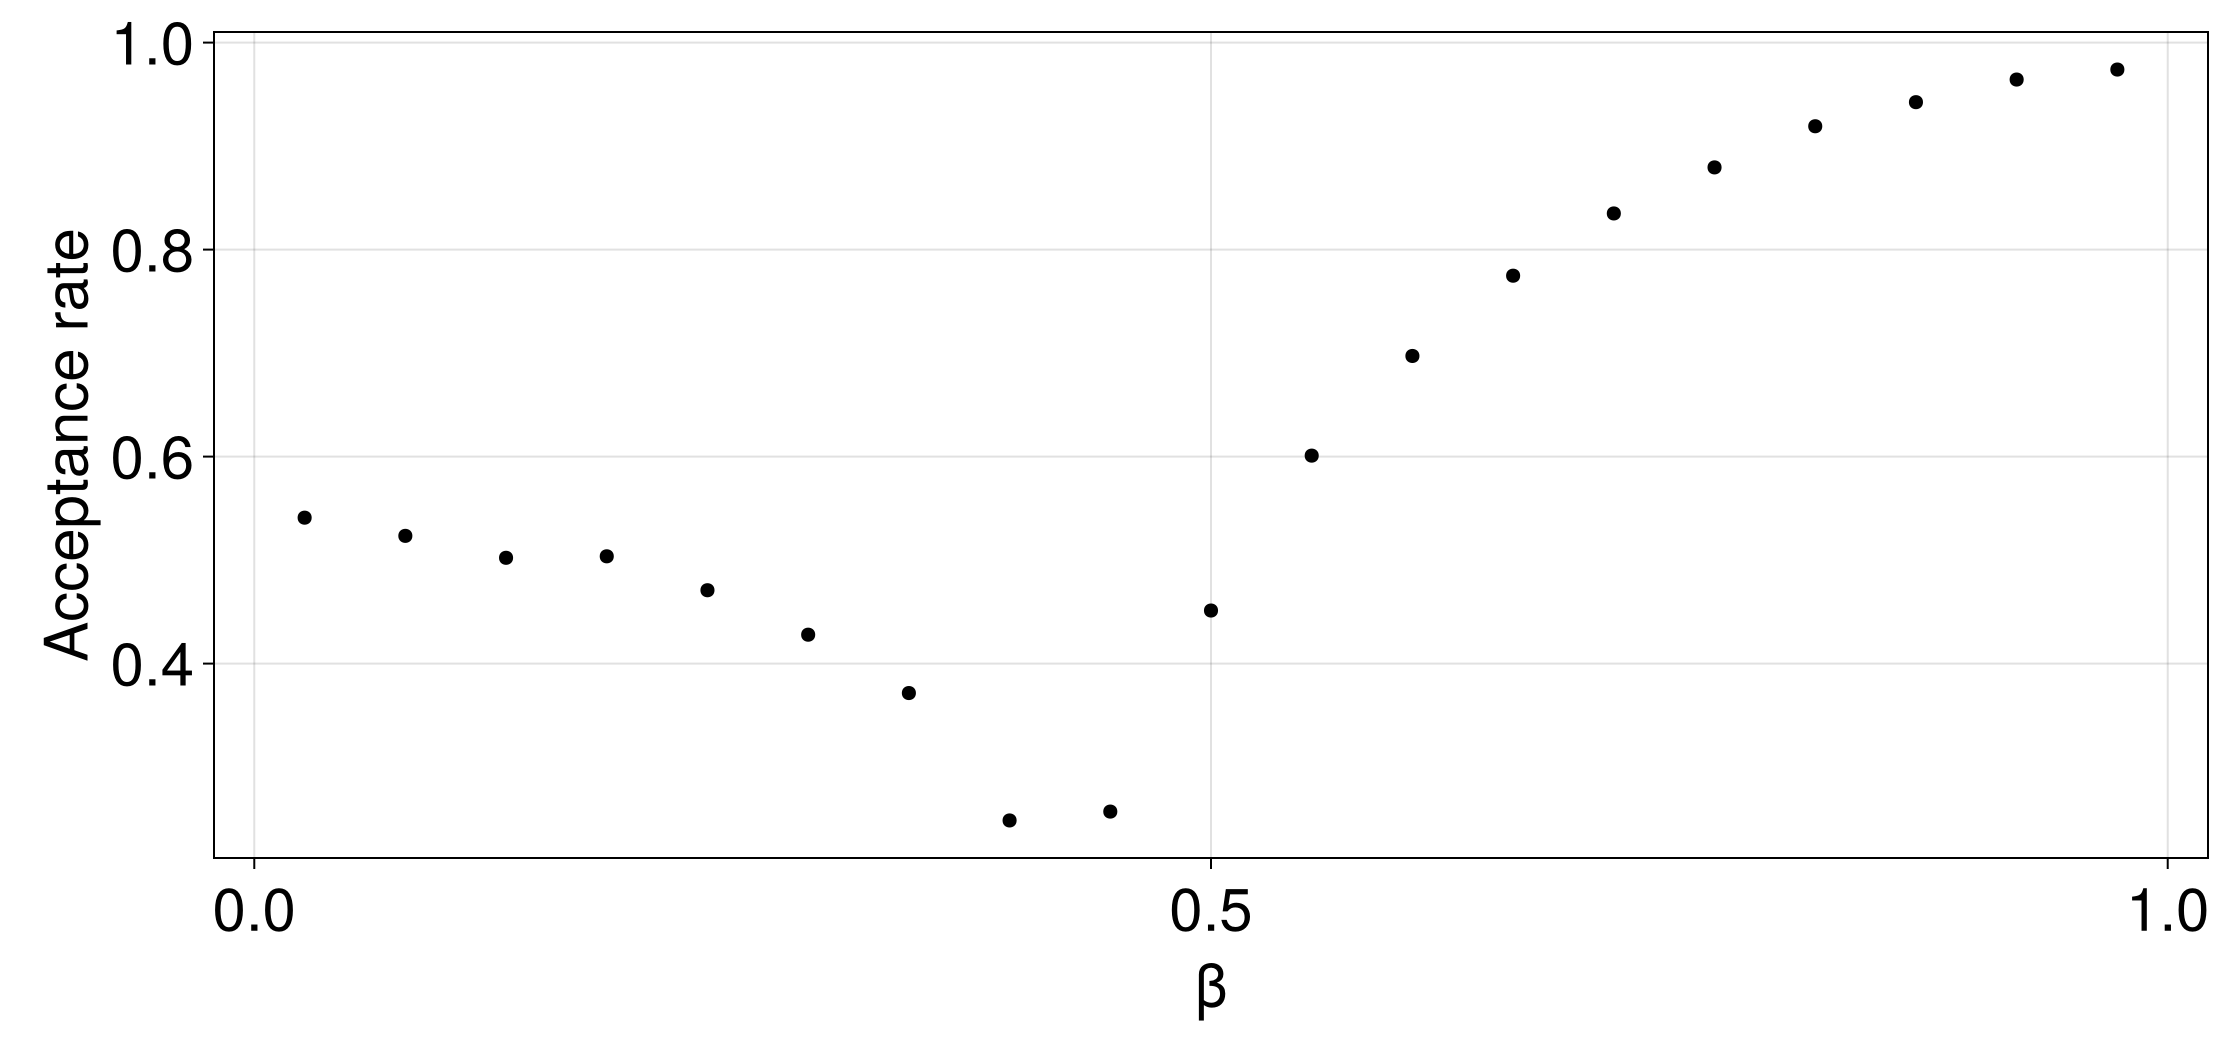

CairoMakie.Screen{IMAGE}


In [4]:
begin
    fig1 = Figure(size=(1120, 525), fontsize = 30)
    ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
    β_mid = [(init_β_ladder[i] + init_β_ladder[i+1]) / 2 for i in 1:length(exchange_prob_means)]
    scatter!(ax1, β_mid, exchange_prob_means, color=:black, markersize=10)
    
    display(fig1)
end

In [5]:
β_ladder = Utils.set_temperature_ladder(β_min, β_max; M=M)
exchange_interval = 1
mcStep_list = [50, 200, 500, 2000, 5000] .* exchange_interval
grad_var_list = []
grad_norm_var_list = []

for mcSteps in mcStep_list
    samples = []
    samples_norm = []
    batch_size = 100000 ÷ mcSteps
    println("MCS: $mcSteps, batch size: $(batch_size)")
    @showprogress for _ in 1:(batch_size)
        grad = IsingCore.score_method(
            N, 
            β_ladder;
            mcSteps=mcSteps,
            exchange_interval=exchange_interval
        )[1]
        grad_norm = [norm(grad[:, i]) for i in 1:size(grad, 2)]
        append!(samples, vec(grad))
        append!(samples_norm, grad_norm)
    end
    samples_matrix = reshape(samples, M, :)
    grad_var = Statistics.var(samples_matrix, dims=2)
    grad_norm_var = Statistics.var(samples_norm)
    push!(grad_var_list, grad_var)
    push!(grad_norm_var_list, grad_norm_var)
end

MCS: 50, batch size: 2000


Progress: 100%|█████████████████████████████████████████| Time: 0:03:38


MCS: 200, batch size: 500


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


MCS: 500, batch size: 200


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


MCS: 2000, batch size: 50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


MCS: 5000, batch size: 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


In [6]:
dir = "../../plots/Ising_model/L=$N/M=$M/evaluate_var"
if dir !== nothing
    mkpath(dir)
end

"../../plots/Ising_model/L=12/M=20/evaluate_var"

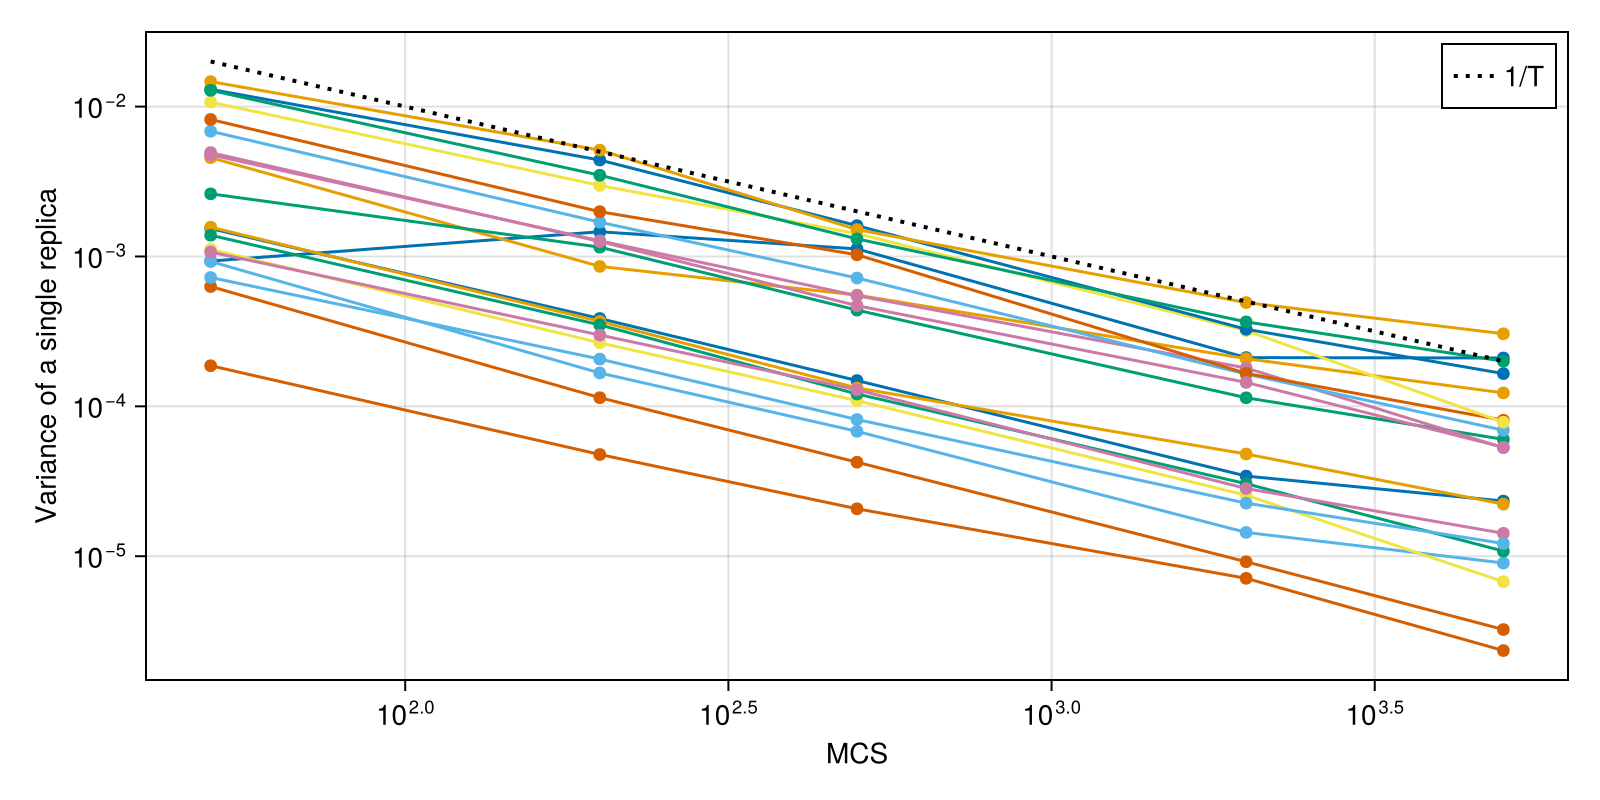

In [7]:
fig1 = Figure(size = (800, 400))
ax1 = Axis(fig1[1, 1],
    xlabel = "MCS",
    ylabel = "Variance of a single replica",
    xscale = log10,
    yscale = log10
)

for r in 1:M
    scatterlines!(
        ax1, 
        mcStep_list, 
        [v[r] for v in grad_var_list], 
        marker=:circle, 
        # label="Replica $(r)"
    )
end
lines!(ax1, mcStep_list, (1)./mcStep_list, label = "1/T", linewidth=2, linestyle=:dot, color=:black)

axislegend(ax1)
display(fig1)
save("$dir/grad_var_vs_mcs.png", fig1; px_per_unit=4)

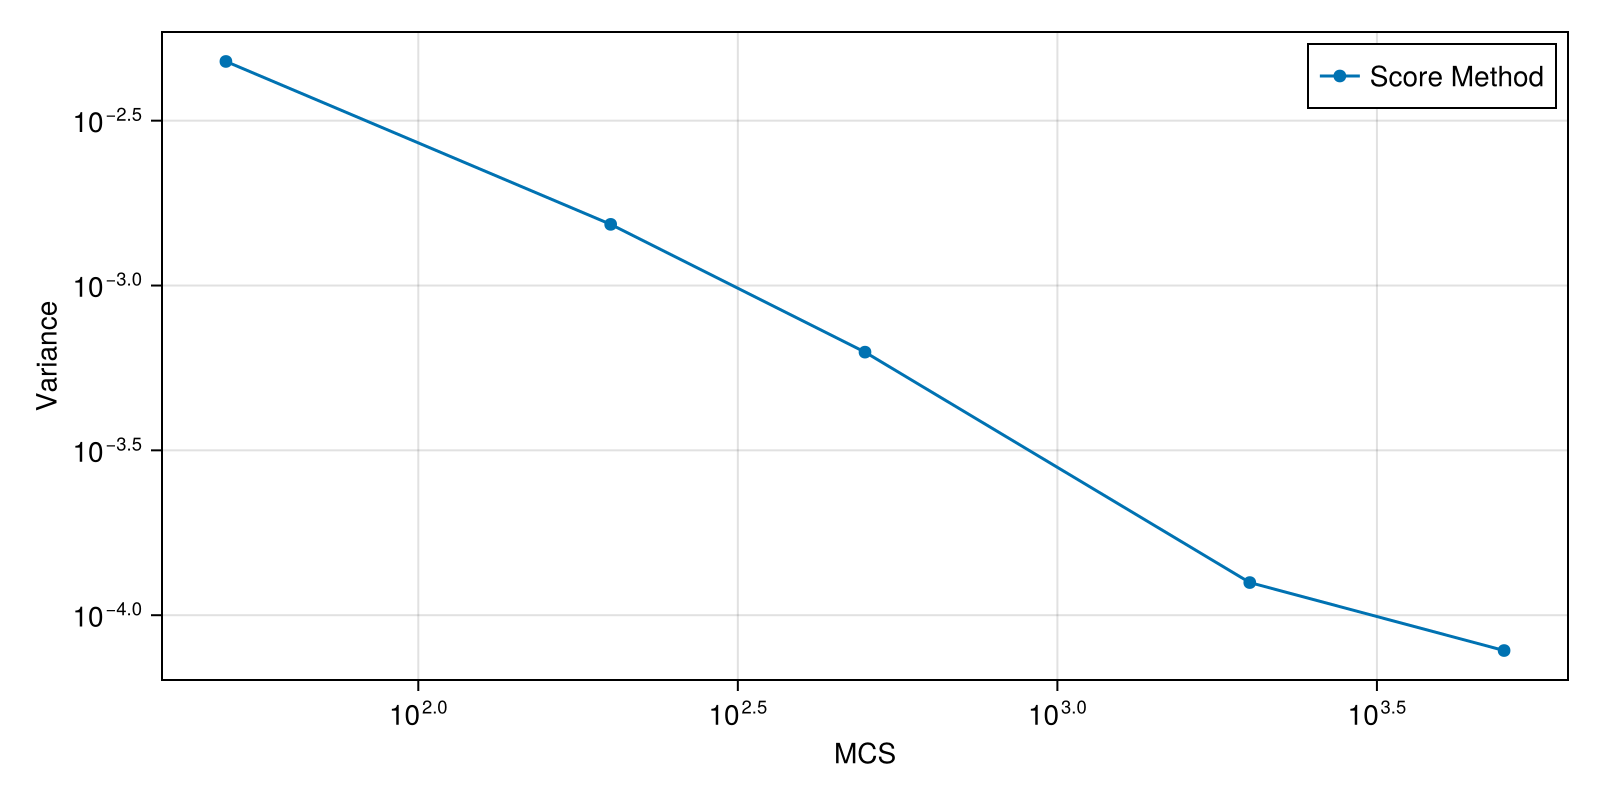

In [8]:
fig2 = Figure(size = (800, 400))
ax2 = Axis(fig2[1, 1],
    xlabel = "MCS",
    ylabel = "Variance",
    xscale = log10,
    yscale = log10
)

scatterlines!(ax2, mcStep_list, grad_norm_var_list, marker=:circle, label="Score Method")
axislegend(ax2)
display(fig2)
save("$dir/grad_norm_var_vs_mcs.png", fig2; px_per_unit=4)

In [9]:
M = 50
β_ladder = Utils.set_temperature_ladder(β_min, β_max; M=M)
samples = [
    IsingCore.score_method(
        N, 
        β_ladder;
        mcSteps=10^4,
        eqSteps=eqSteps,
        exchange_interval=10
    )[1] for _ in 1:100
]
println("mean = $(Statistics.mean(samples))")
println("std = $(Statistics.std(samples))")

mean = [-0.0031063829410209343, -0.0007123360235073269, -0.00016022700341131592, -2.6165706762123392e-5, -0.0004769653842287252, 0.0003022499127432352, -0.00031970249151190317, -0.0004861540572659649, 0.0001300526465254924, -0.0007049197058504909, 3.1424253017285715e-6, -0.00023597970427504007, -0.0002790632878218158, -0.0007566632543285495, -0.00022557441011225834, -5.954010462283362e-5, -0.0006370512299404017, -0.0027510708768913542, -0.0023661920834587933, -0.003215582420086645, -0.005721305045576891, 0.003457034997619596, 0.004736491975686833, 0.0029308166272595066, 0.002446777742791919, 0.0019778095892672475, 0.001560049149864926, 0.0015834836313940437, 0.0014002892279843227, 0.001525837771344807, 0.0013326555204864487, 0.0013334682990767234, 0.001263843066360151, 0.0014246829065640019, 0.0016980191571178051, 0.0012275326522276943, 0.0014124937928182376, 0.0013077457224931646, 0.0011754122467323776, 0.0012756876424135266, 0.0011867011571018485, 0.0010061847412912808, 0.00078720272

In [10]:
mean_grad = Vector{Float64}(undef, M)
median_grad = Vector{Float64}(undef, M)
q1_grad = Vector{Float64}(undef, M)
q3_grad = Vector{Float64}(undef, M)

for i in 1:M
    ith_replica_data = [run[i] for run in samples]
    mean_grad[i] = Statistics.mean(ith_replica_data)
    quantiles = quantile(ith_replica_data, [0.25, 0.5, 0.75])
    q1_grad[i]     = quantiles[1]
    median_grad[i] = quantiles[2]
    q3_grad[i]     = quantiles[3]
end

low_errors = median_grad .- q1_grad
high_errors = q3_grad .- median_grad

50-element Vector{Float64}:
 0.0005984067400537146
 0.0014766258974757338
 0.0013536143555095042
 0.0013290032158855783
 0.0015305115872165705
 0.0015855520754442694
 0.0016366650516736738
 0.0016330472320429013
 0.0019002160737104077
 0.001522889906573616
 ⋮
 0.000747014646926226
 0.0008993973219052018
 0.0007529160073321184
 0.000584404553095668
 0.0007695054921741896
 0.0005653918530402872
 0.0004067385234004748
 0.0004894180606458611
 0.00038498717482048344

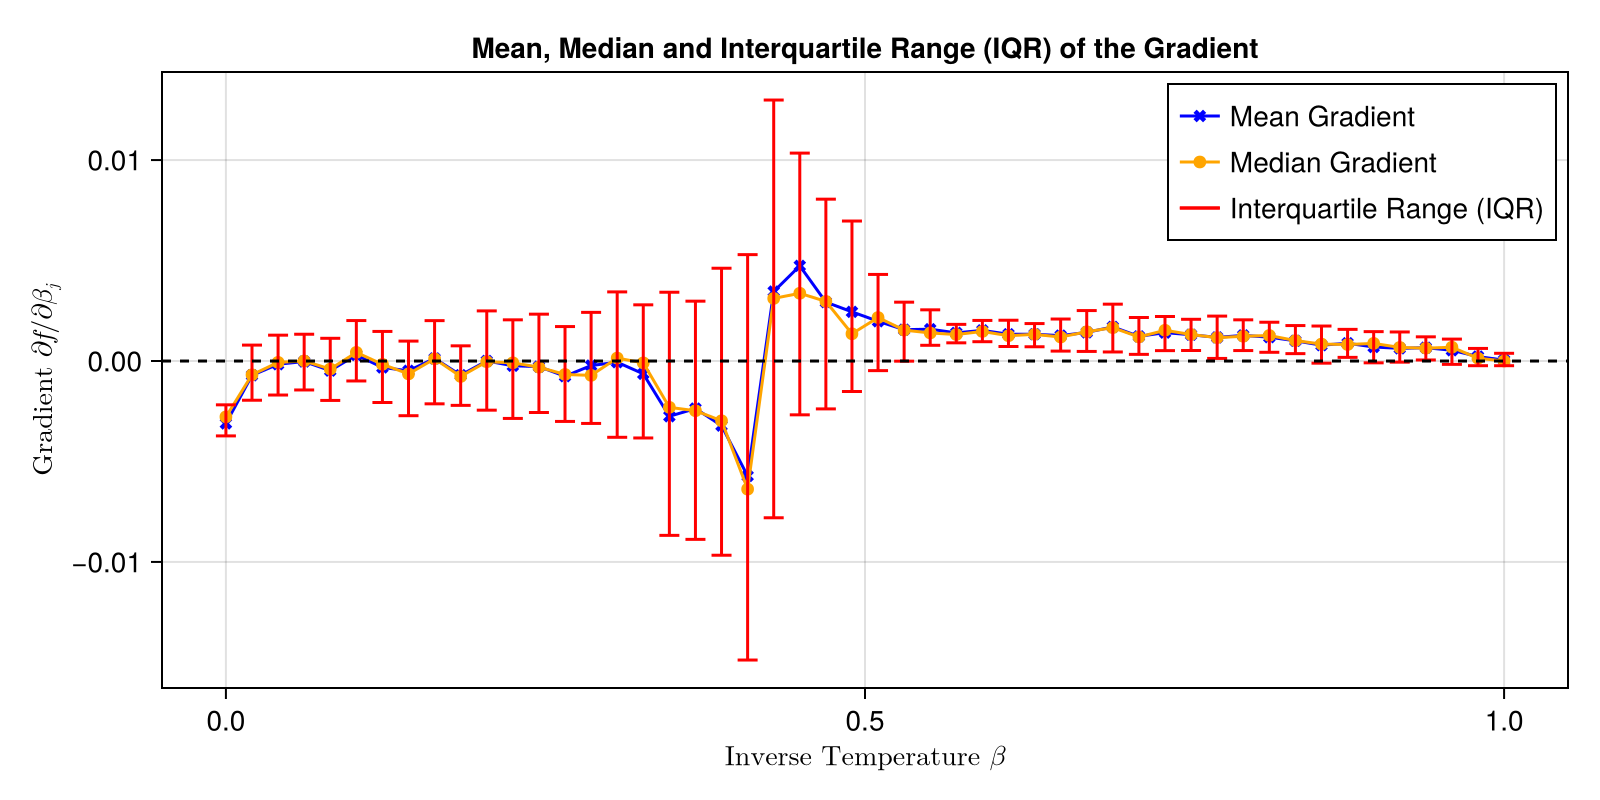

In [11]:
fig1 = Figure(size = (800, 400))
ax1 = Axis(fig1[1, 1],
    title = "Mean, Median and Interquartile Range (IQR) of the Gradient",
    xlabel = L"\text{Inverse Temperature } \beta",
    ylabel = L"\text{Gradient } \partial f / \partial \beta_j"
)

scatterlines!(ax1, β_ladder, mean_grad, marker=:xcross, color=:blue, label="Mean Gradient")
scatterlines!(ax1, β_ladder, median_grad, marker=:circle, color=:orange, label="Median Gradient")
errorbars!(ax1, β_ladder, median_grad, low_errors, high_errors, color=:red, whiskerwidth=10, label="Interquartile Range (IQR)")

hlines!(ax1, [0], color=:black, linestyle=:dash)
axislegend(ax1)

display(fig1)
save("$dir/Mean, Median and Interquartile Range of the Gradient.png", fig1; px_per_unit=4)

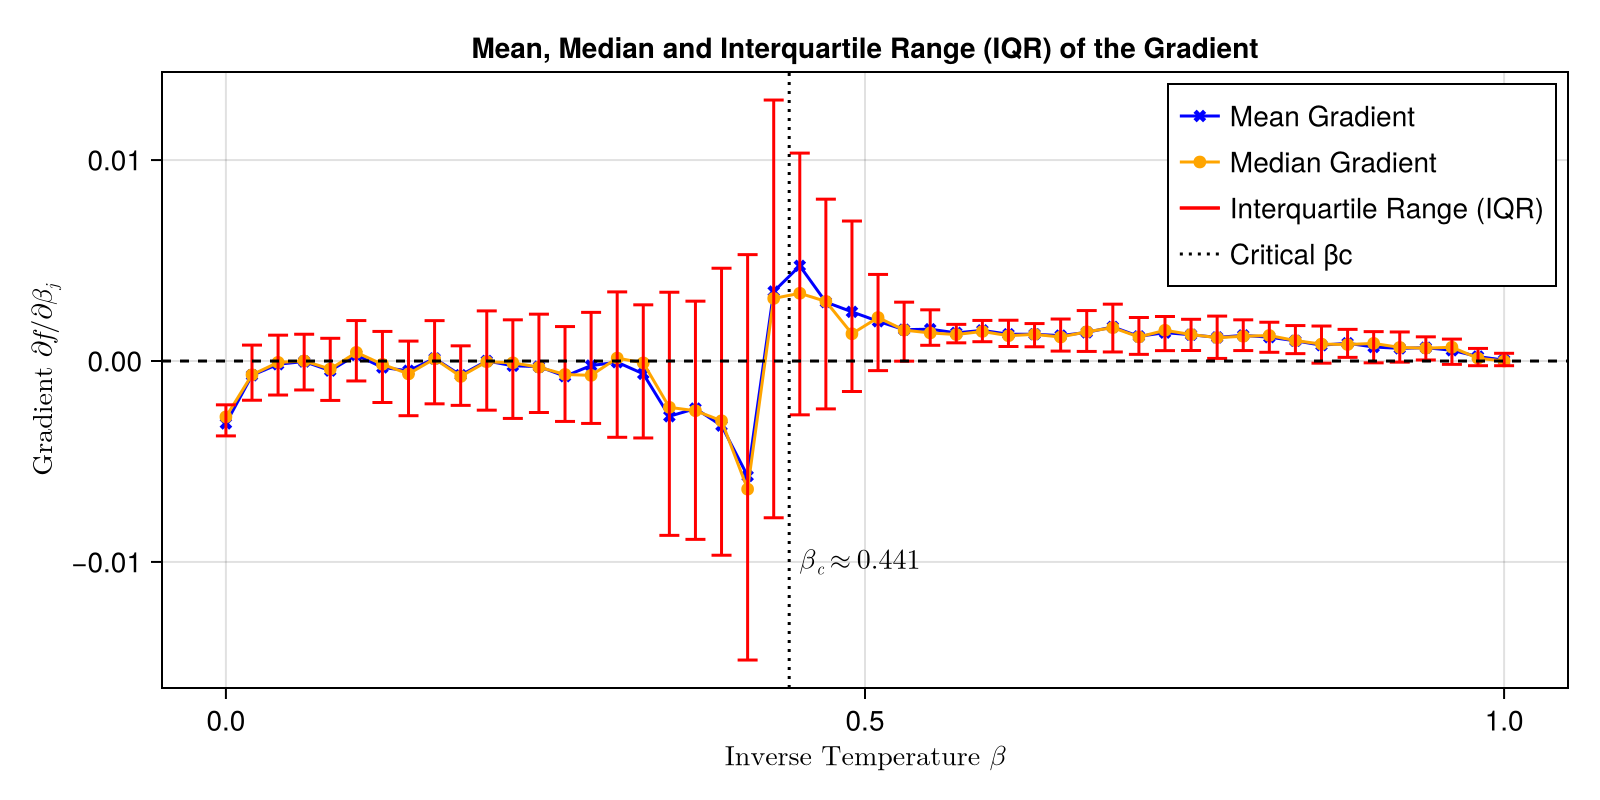

In [18]:
fig1 = Figure(size = (800, 400))
ax1 = Axis(fig1[1, 1],
    title = "Mean, Median and Interquartile Range (IQR) of the Gradient",
    xlabel = L"\text{Inverse Temperature } \beta",
    ylabel = L"\text{Gradient } \partial f / \partial \beta_j"
)

scatterlines!(ax1, β_ladder, mean_grad, marker=:xcross, color=:blue, label="Mean Gradient")
scatterlines!(ax1, β_ladder, median_grad, marker=:circle, color=:orange, label="Median Gradient")
errorbars!(ax1, β_ladder, median_grad, low_errors, high_errors, color=:red, whiskerwidth=10, label="Interquartile Range (IQR)")
hlines!(ax1, [0], color=:black, linestyle=:dash)

β_c = log(1 + sqrt(2)) / 2

vlines!(ax1, [β_c], color=:black, linestyle=:dot, label="Critical βc")

y_pos = -0.01
text!(ax1,
    L"\beta_c \approx %$(round(β_c, digits=3))", 
    position = (β_c, y_pos), 
    align = (:left, :center), 
    offset = (5, 0)
)

axislegend(ax1)
display(fig1)
save("$dir/Mean, Median and Interquartile Range of the Gradient with Critical Beta.png", fig1; px_per_unit=4)

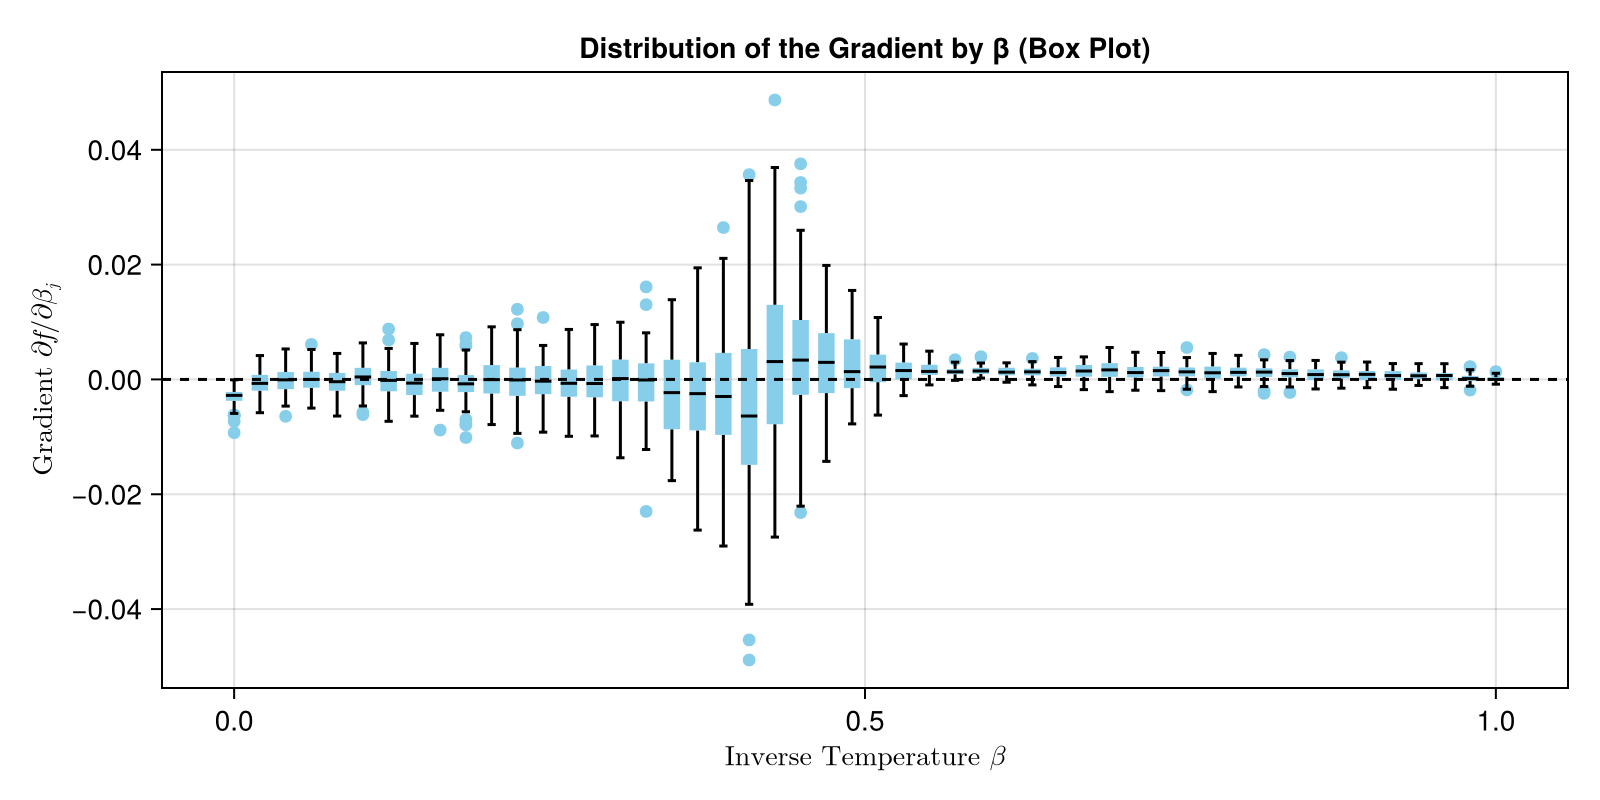

In [13]:
num_samples = length(samples)
y_data = vcat([[run[i] for run in samples] for i in 1:M]...)
x_positions = repeat(β_ladder, inner = num_samples)

min_dist = minimum(diff(β_ladder))
box_width = min_dist * 0.8

fig_box = Figure(size = (800, 400))
ax_box = Axis(fig_box[1, 1],
    title = "Distribution of the Gradient by β (Box Plot)",
    xlabel = L"\text{Inverse Temperature } \beta",
    ylabel = L"\text{Gradient } \partial f / \partial \beta_j"
)

boxplot!(ax_box, x_positions, y_data,
    color = :skyblue,
    whiskerwidth = 0.5,
    width = box_width,
)

hlines!(ax_box, [0], color=:black, linestyle=:dash)
display(fig_box)
save("$dir/Distribution of the Gradient by β (Box Plot).png", fig_box; px_per_unit=4)

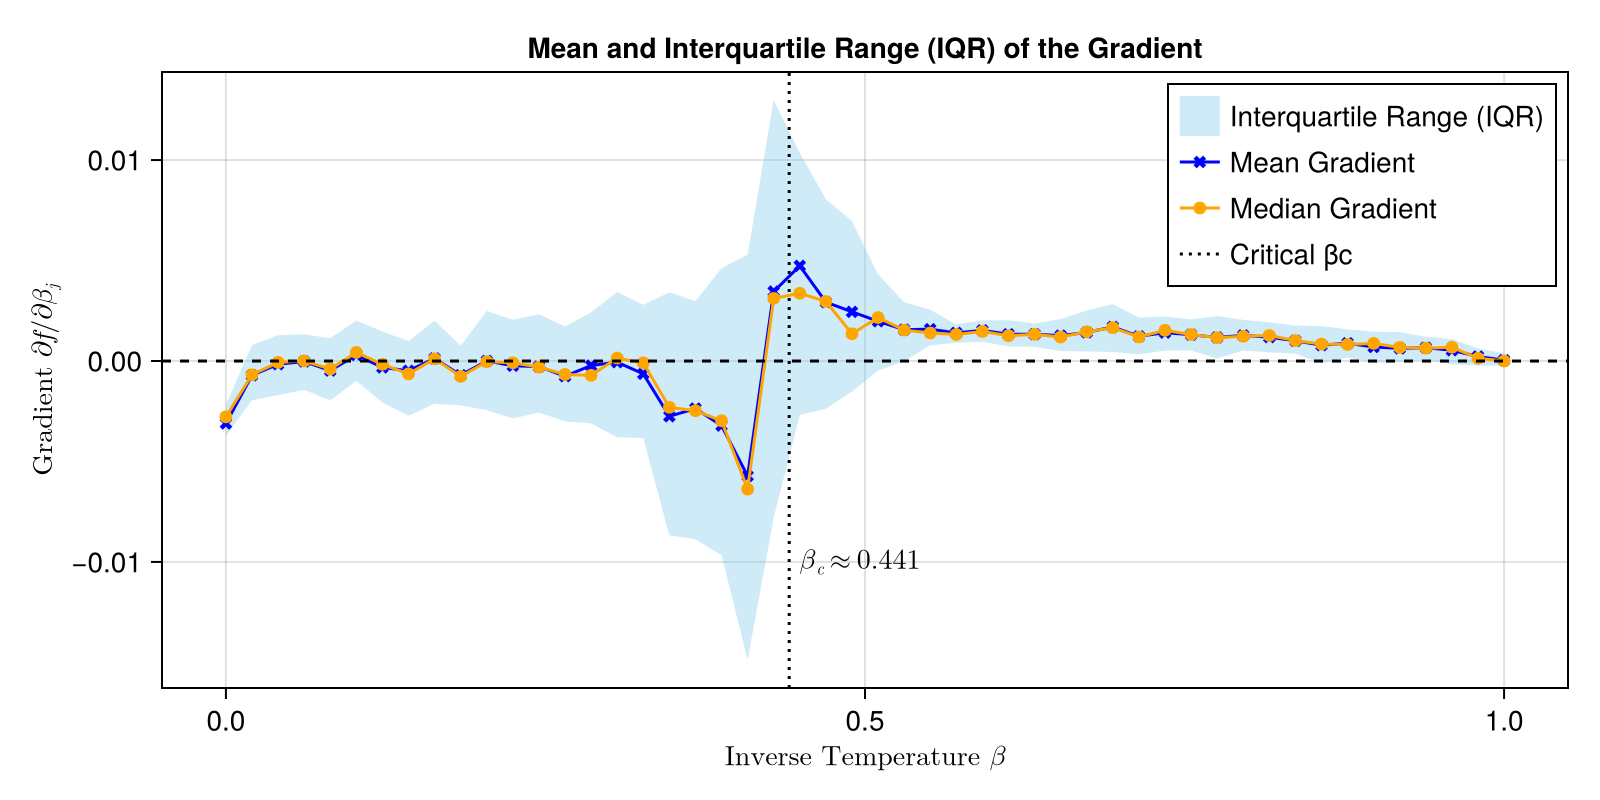

In [19]:
fig2 = Figure(size = (800, 400))
ax2 = Axis(fig2[1, 1],
    title = "Mean and Interquartile Range (IQR) of the Gradient",
    xlabel = L"\text{Inverse Temperature } \beta",
    ylabel = L"\text{Gradient } \partial f / \partial \beta_j"
)

band!(ax2, β_ladder, q1_grad, q3_grad, color=(:skyblue, 0.4), label="Interquartile Range (IQR)")

scatterlines!(ax2, β_ladder, mean_grad, marker=:xcross, color=:blue, label="Mean Gradient")
scatterlines!(ax2, β_ladder, median_grad, marker=:circle, color=:orange, label="Median Gradient")

hlines!(ax2, [0], color=:black, linestyle=:dash)

β_c = log(1 + sqrt(2)) / 2

vlines!(ax2, [β_c], color=:black, linestyle=:dot, label="Critical βc")

y_pos = -0.01
text!(ax2,
    L"\beta_c \approx %$(round(β_c, digits=3))", 
    position = (β_c, y_pos), 
    align = (:left, :center), 
    offset = (5, 0)
)

axislegend(ax2)
display(fig2)
save("$dir/Mean and Interquartile Range of the Gradient.png", fig2; px_per_unit=4)

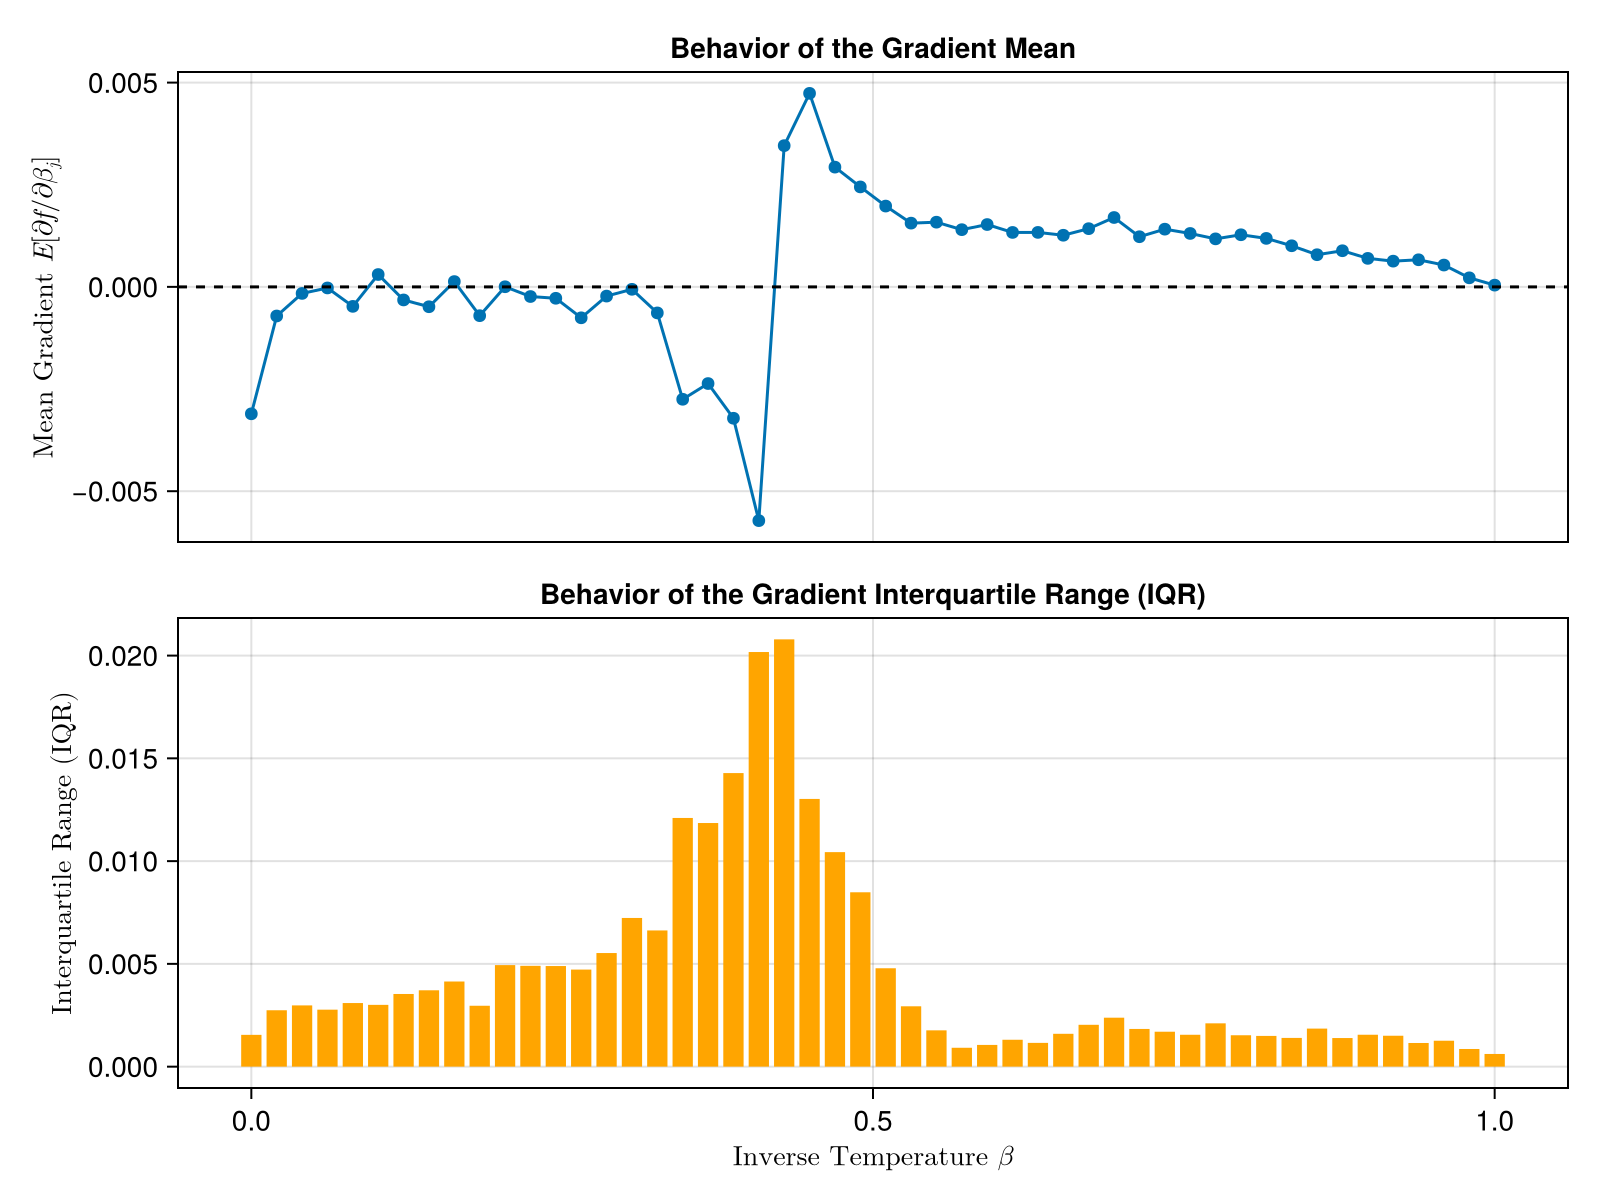

In [15]:
iqr_grad = q3_grad .- q1_grad

fig3 = Figure(size = (800, 600))

ax3_top = Axis(fig3[1, 1],
    title = "Behavior of the Gradient Mean",
    ylabel = L"\text{Mean Gradient } E[\partial f / \partial \beta_j]"
)

scatterlines!(ax3_top, β_ladder, mean_grad, marker=:circle)
hlines!(ax3_top, [0], color=:black, linestyle=:dash)
hidexdecorations!(ax3_top, grid = false)

ax3_bottom = Axis(fig3[2, 1],
    title = "Behavior of the Gradient Interquartile Range (IQR)",
    xlabel = L"\text{Inverse Temperature } \beta",
    ylabel = L"\text{Interquartile Range (IQR)}",
)

barplot!(ax3_bottom, β_ladder, iqr_grad, color=:orange)
linkxaxes!(ax3_top, ax3_bottom)

display(fig3)
save("$dir/Behavior of the Gradient Mean and IQR.png", fig3; px_per_unit=4)